In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

sns.set()

# Anomaly detection in NHAMCS data

## Loading the dataset

The NHAMCS dataset is loaded, where aach row represents a patient visit. All columns except those related to the date of the visit and the reason for the visit are discarded. The primary reason for visit column (RFV1) is categorical, with each symptom being assigned a unique numeric code.

Here, the visit year, month, and day are combined into a datetime and the original date columns are discarded.

In [2]:
years = [
    2015,
    2016,
    2017,
    2018,
]

cols = [
    'VMONTH',
    'VDAYR',
    'RFV1',
]

col_rename = {
    'VMONTH': 'month',
    'VDAYR': 'day',
}

na = {
    'RFV1': -9,
}

def get_nhamcs_data(years):
    for year in years:
        df = pd.read_csv(
            os.path.join('data', 'nhamcs{}.csv'.format(year)),
            usecols=cols,
            na_values=na,
        )
        df['year'] = year
        yield df

frames = list(get_nhamcs_data(years))
nhamcs = pd.concat(frames, join='inner', ignore_index=True)

nhamcs.rename(columns=col_rename, inplace=True)
nhamcs['date'] = pd.to_datetime(nhamcs[['year', 'month', 'day']])
nhamcs.drop([
        'year',
        'month',
        'day',
    ],
    axis=1,
    inplace=True,
)

nhamcs.head(10)

,RFV1,date
0,19351.0,2015-11-02
1,52250.0,2015-11-02
2,12100.0,2015-11-03
3,19451.0,2015-11-04
4,19601.0,2015-11-04
5,28000.0,2015-11-05
6,12100.0,2015-11-06
7,45550.0,2015-11-07
8,34150.0,2015-11-01
9,52100.0,2015-11-02


## Creating feature vectors

The reasons for the visit are restricting to only those associated with flu-like symptoms. The categorical information is replaced with a new one-hot encoding, with one column for each symptom.

To create the feature vectors, the data are grouped by date with each row representing a day and each column a unique symptom. For each day, the number of patients visiting for each symptom are summed, and then divided by the total number of visits.

In [3]:
import rfv

nhamcs = nhamcs[nhamcs["RFV1"].isin(rfv.rfv1)].reindex()

onehot = pd.get_dummies(nhamcs['RFV1'], prefix='RFV')
nhamcs.drop('RFV1', axis=1, inplace=True)
nhamcs = nhamcs.join(onehot)

syndromic_features = nhamcs.groupby('date').sum().apply(lambda row: row/float(row.sum()))
syndromic_features.head()

,RFV_10050.0,RFV_10100.0,RFV_10150.0,RFV_10200.0,RFV_10250.0,RFV_10300.0,RFV_10350.0,RFV_10352.0,RFV_10353.0,RFV_10500.0,...,RFV_14851.0,RFV_15250.0,RFV_15300.0,RFV_15350.0,RFV_15400.0,RFV_15450.0,RFV_15451.0,RFV_16150.0,RFV_19651.0,RFV_46050.0
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.000000,0.001638,0.000000,0.004208,0.005291,0.005660,0.011111,0.0,0.0,0.0,...,0.0,0.003594,0.002099,0.0,0.0,0.000000,0.003647,0.019608,0.0,0.008065
2015-01-02,0.017241,0.003932,0.000000,0.004208,0.005291,0.003774,0.000000,0.0,0.0,0.0,...,0.0,0.003594,0.002099,0.0,0.0,0.007042,0.003242,0.039216,0.0,0.000000
2015-01-03,0.000000,0.003277,0.005587,0.001403,0.000000,0.007547,0.000000,0.0,0.0,0.0,...,0.0,0.004492,0.001400,0.0,0.0,0.000000,0.002432,0.019608,0.0,0.000000
2015-01-04,0.000000,0.003604,0.000000,0.001403,0.010582,0.001887,0.011111,0.0,0.0,0.0,...,0.0,0.001797,0.002799,0.0,0.0,0.000000,0.003242,0.019608,0.0,0.000000
2015-01-05,0.000000,0.004260,0.000000,0.002805,0.005291,0.001887,0.000000,0.0,0.0,0.0,...,0.0,0.005391,0.001400,0.0,0.0,0.003521,0.003850,0.019608,0.0,0.004032


## Plotting some the features

A plot of several years of the prevalence of a cough (symptom 14400) shows that there is clearly an increase in the prevalence over the winter months.

<AxesSubplot:xlabel='Date', ylabel='Prevalence'>

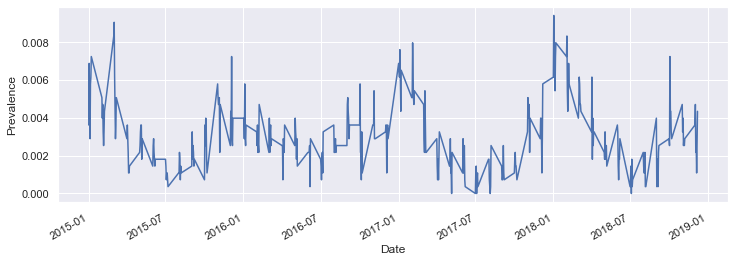

In [4]:
syndromic_features['RFV_14400.0'].plot(xlabel='Date', ylabel='Prevalence', figsize=(12,4))